# Use T2I-Adapters for Stable Diffusion XL (SDXL) to mess with images, this episode: **sketch adapter**

Official example:
![](https://camo.githubusercontent.com/e5fdc53a1c9b9ca2c500aacac2cde00fd5e5cd012a89ca0f7c62f607f17010e2/68747470733a2f2f68756767696e67666163652e636f2f416461707465722f743269616461707465722f7265736f6c76652f6d61696e2f745f736b657463682e504e47)

# Install the necessary packages
probably some missing ..

In [1]:
!pip freeze | egrep "diffusers|controlnet"

controlnet-aux==0.0.7
diffusers==0.23.1


# Download a random image

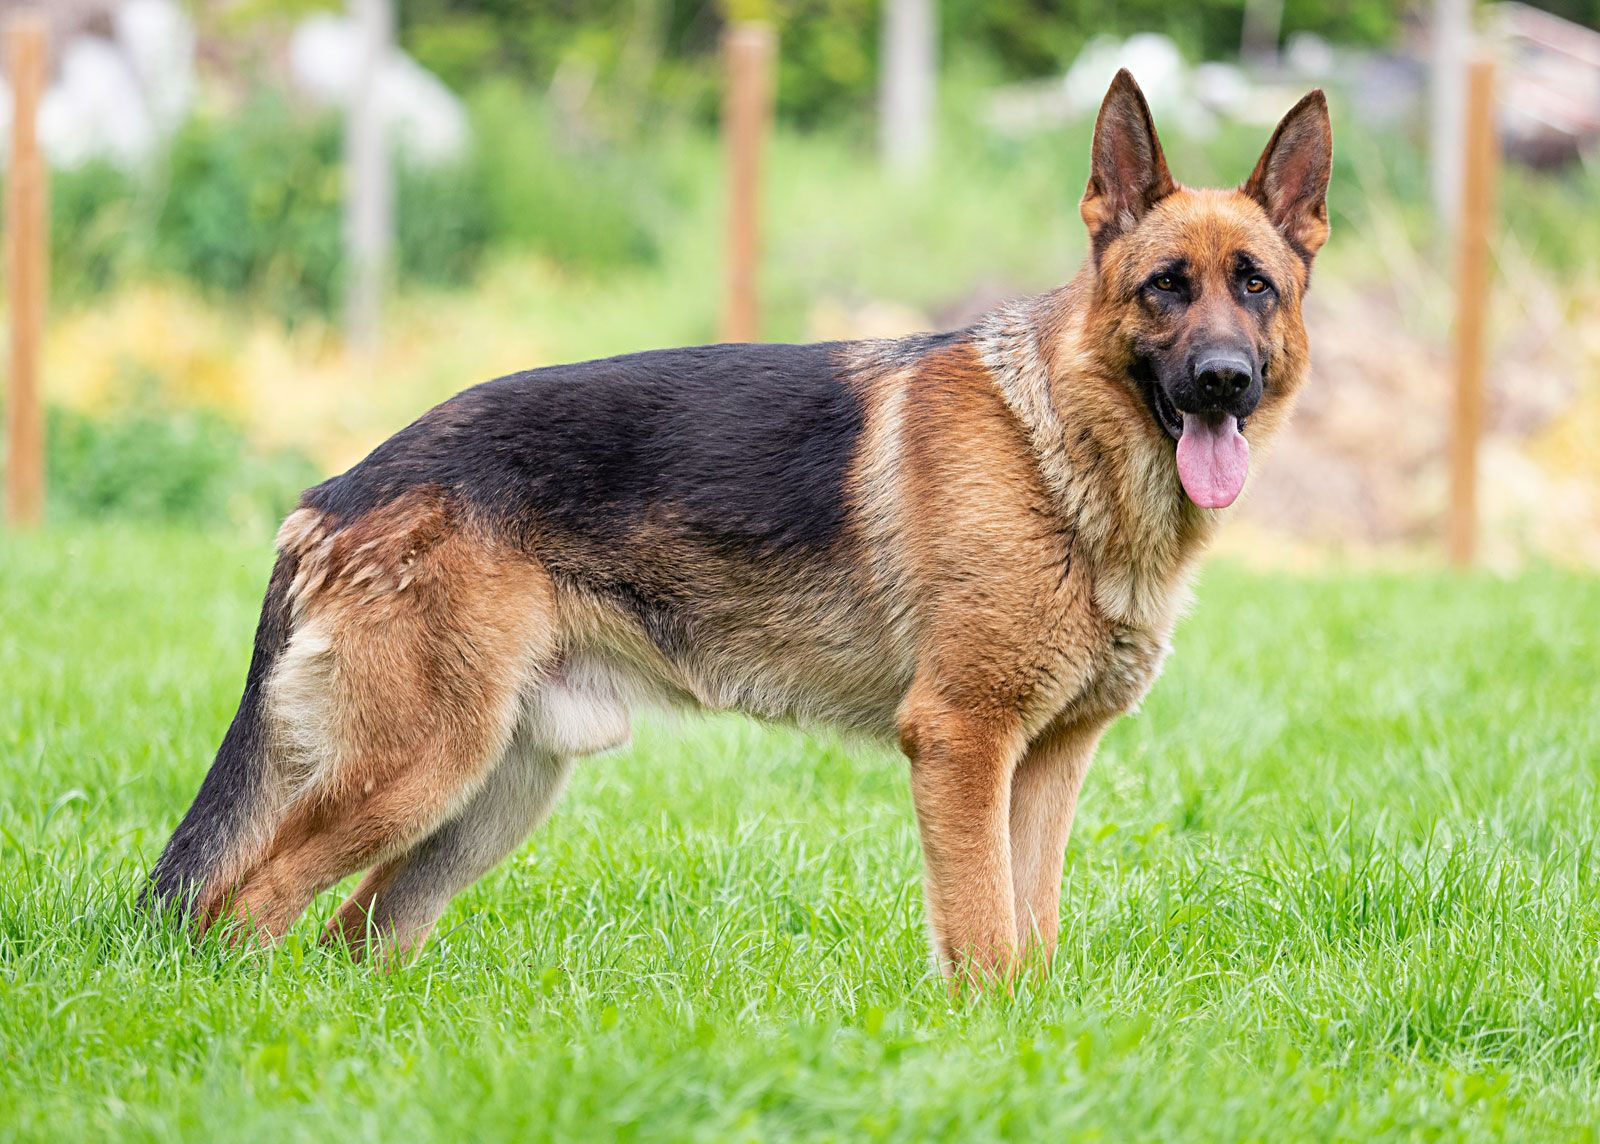

In [47]:
import io
import requests
from diffusers.utils import load_image
from PIL import Image

url="https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg"

aux_im = Image.open(io.BytesIO(requests.get(url, stream=True).content))
image_input = load_image(aux_im)
image_input

# Turn img into sketch, scale and convert to greyscale

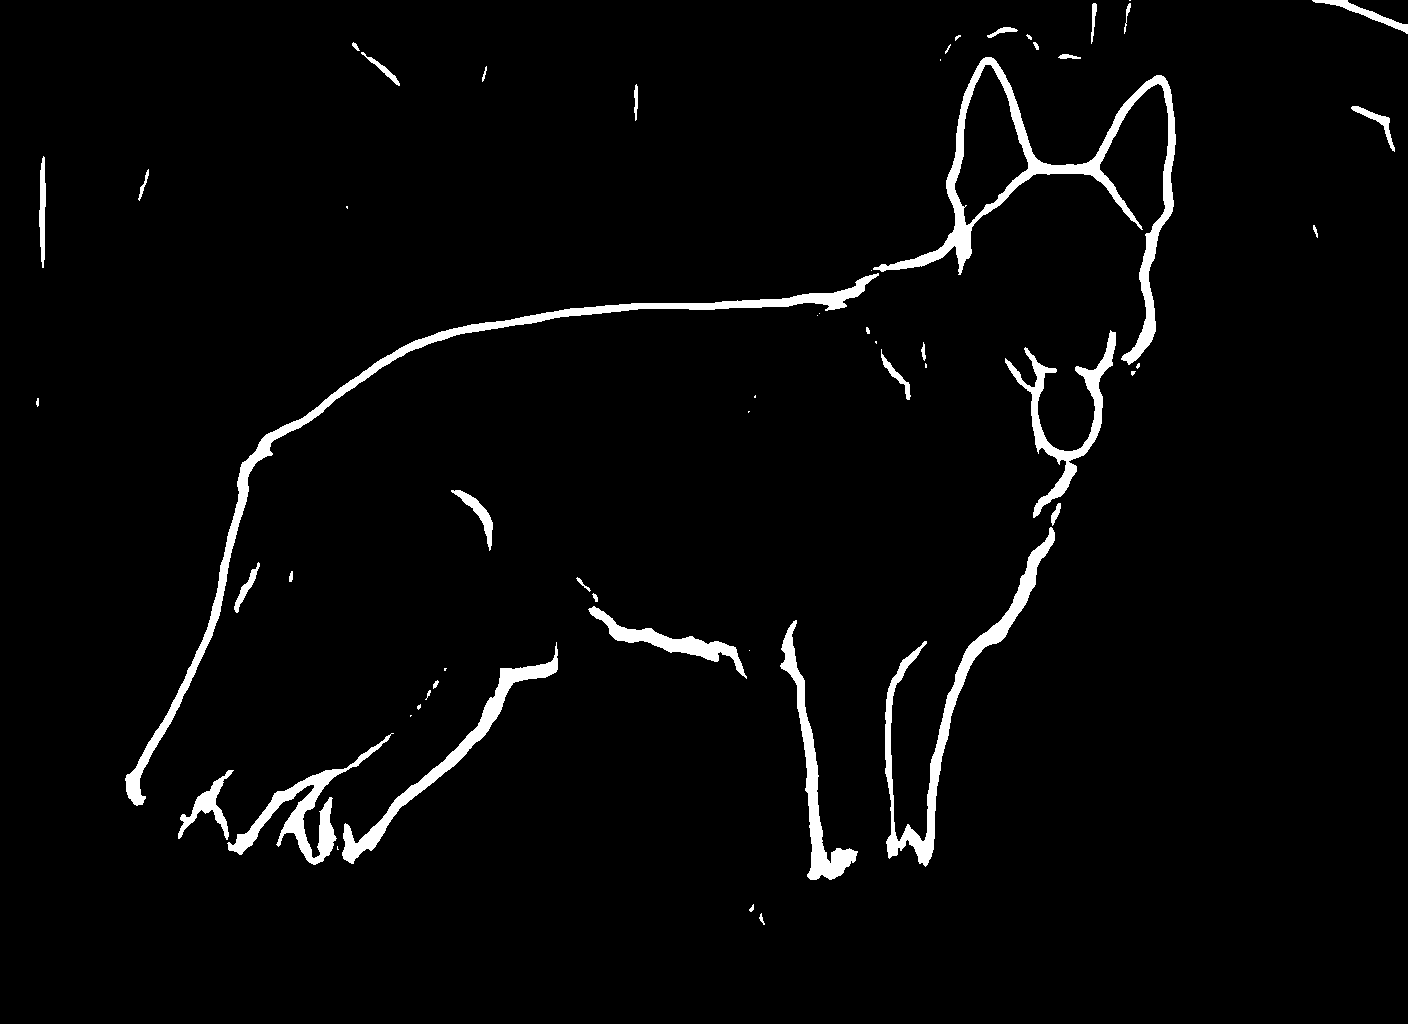

In [48]:
from controlnet_aux.pidi import PidiNetDetector

preprocessor = PidiNetDetector.from_pretrained("lllyasviel/Annotators").to("cuda")
image_preprocessed = preprocessor(image_input, detect_resolution=1024, image_resolution=1024,apply_filter=True).convert("L")

image_preprocessed

# Load Stable Diffusion XL and T2I Adapters
this will take a **LOT** of disk space

In [4]:
!du -hs models/* | egrep "stable|t2i"  

60G	models/stable-diffusion-xl-base-1.0
942M	models/t2iadapter


In [57]:
import torch
from diffusers import (
    T2IAdapter,
    StableDiffusionXLAdapterPipeline,
    DDPMScheduler,
    AutoencoderKL,
    EulerAncestralDiscreteScheduler
)
from diffusers.utils import load_image

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
adapter = T2IAdapter.from_pretrained("Adapter/t2iadapter", subfolder="sketch_sdxl_1.0", torch_dtype=torch.float16, adapter_type="full_adapter_xl")
euler_a = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
vae=AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

pipe = StableDiffusionXLAdapterPipeline.from_pretrained(
    model_id, 
    adapter=adapter, 
    vae=vae,
    scheduler=euler_a,
    torch_dtype=torch.float16, 
    variant="fp16", 
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
!nvidia-smi

Thu Nov 23 17:53:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:01:00.0 Off |                  N/A |
| 30%   42C    P2             104W / 230W |   7368MiB / 24576MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Feed the pipeline
* ```prompt```: What you would like to see
* ```negative_prompt```: What you **don't** want see (constant for me, regardless of prompt)
* ```guidance_scale```: How much emphasis to put on prompt (as opposed to sketch); range: no idea, default 7.5, always worked fine for me, independent of prompt/sketch
* ```num_inference_steps```: Number of denoising steps, **the more the better the picture** (and the longer it takes). default: 50. Draft with 10, at 30+ you get a decent picture
* ```adapter_conditioning_scale```: Impact of adapter (ie. sketch) on image (range 0-1, default 1.0, my inital choice: 0.9).
* ```adapter_conditioning_factor```: To how many of the inital steps the adapter is applied (range 0-1, default 1.0, my inital choice: 0.9)

The last two parameters need the most tweaking. 

More: https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/adapter#diffusers.StableDiffusionXLAdapterPipeline

  0%|          | 0/40 [00:00<?, ?it/s]

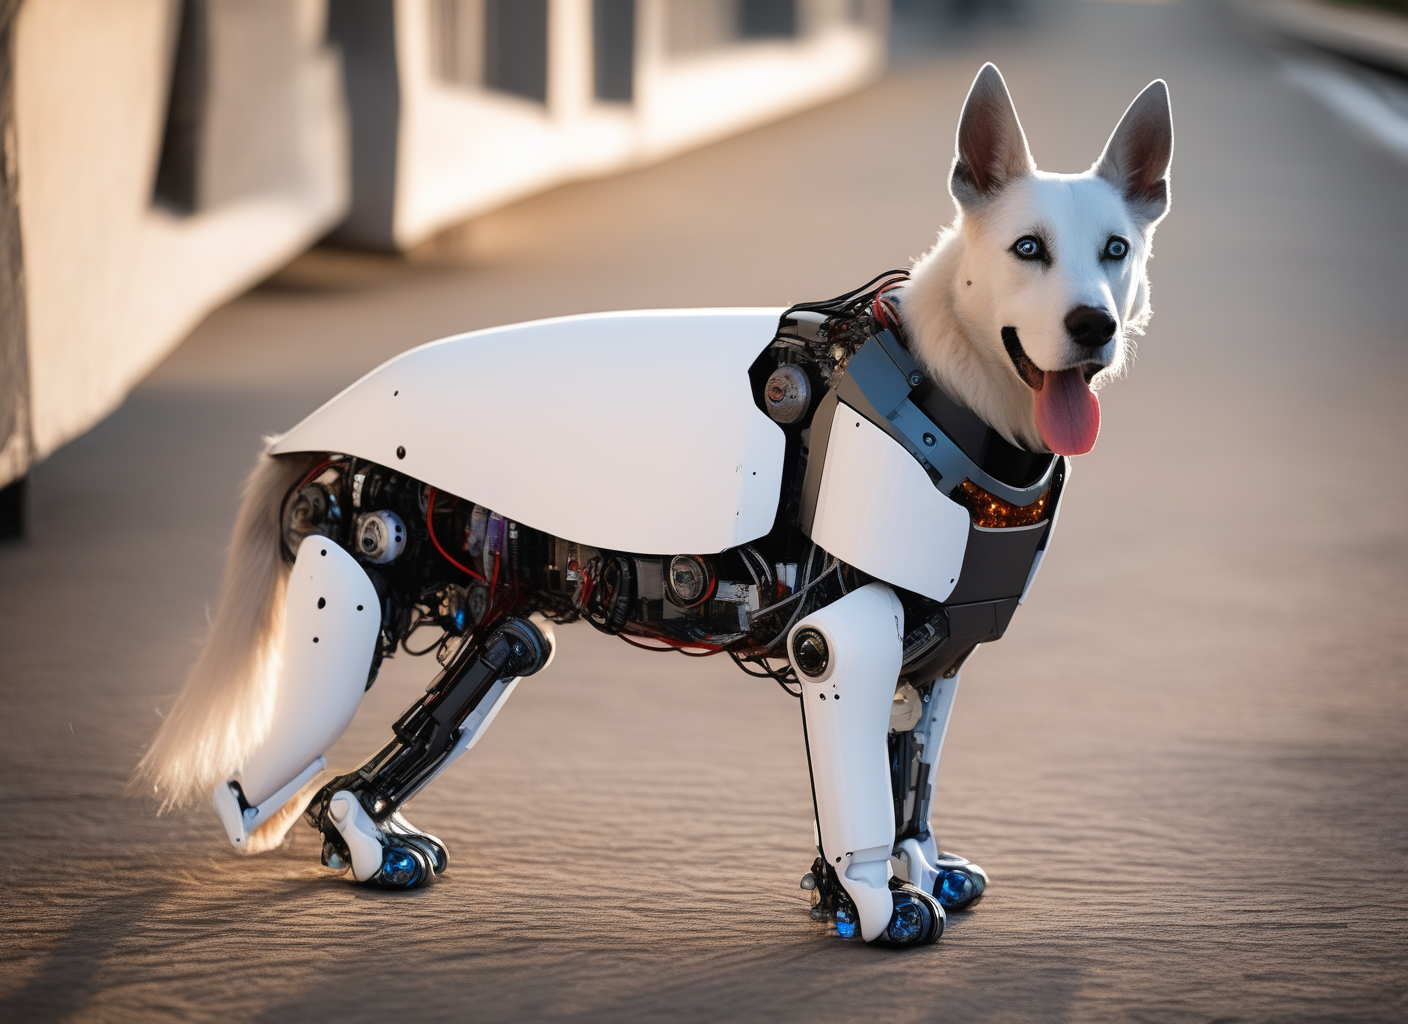

In [78]:
prompt="a robot dog in real world"

image=pipe(
        prompt=prompt,
        negative_prompt=f"disfigured, extra digit, fewer digits, cropped, worst quality, low quality",
        image=image_preprocessed,
        guidance_scale=7.5,
        num_inference_steps=40,
        adapter_conditioning_scale=1,
        adapter_conditioning_factor=0.8,
    ).images[0]
image

/tmp/ipykernel_7083/920589910.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, desired_height), Image.ANTIALIAS)
/tmp/ipykernel_7083/920589910.py:20: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(label, font=font)


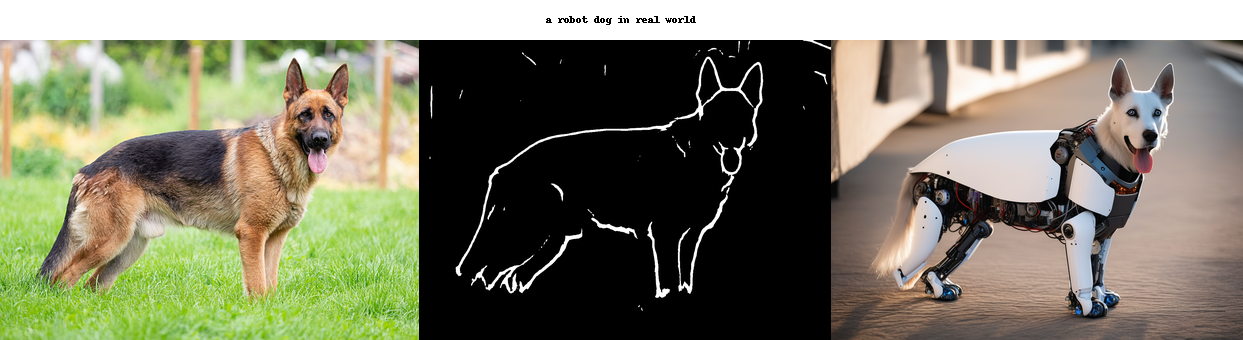

In [79]:
from PIL import Image, ImageDraw, ImageFont

def create_image_gallery(images, desired_height=300, label=None):
    # Resize images to the same height while maintaining the aspect ratio
    resized_images = []
    for img in images:
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)
        resized_img = img.resize((new_width, desired_height), Image.ANTIALIAS)
        resized_images.append(resized_img)

    total_width = sum(img.width for img in resized_images)
    label_height = 40  # Adjust as needed for label size

    gallery_image = Image.new('RGB', (total_width, desired_height + label_height), 'white')

    if label:
        draw = ImageDraw.Draw(gallery_image)
        font = ImageFont.load_default()  # Load a default font
        text_width, text_height = draw.textsize(label, font=font)
        text_x = (total_width - text_width) // 2
        text_y = (label_height - text_height) // 2
        draw.text((text_x, text_y), label, fill="black", font=font)

    current_x = 0
    for img in resized_images:
        gallery_image.paste(img, (current_x, label_height))
        current_x += img.width

    return gallery_image

gall=create_image_gallery([image_input, image_preprocessed, image ], label=prompt)
gall.save("gallery_img2sketch2img.png")
gall